In [1]:
import ferret
import test.MBABlast_dataset as mbaobf_dataset

import numpy as np
import matplotlib.pyplot as plt
import time
import itertools
import random

In [2]:
SAMPLE_AMOUNT = 250

In [3]:
random.seed(1337) # todo: when actual evaluating rng dependent code, go over multiple seeds and form an average

In [4]:
DATASET = lambda: mbaobf_dataset.getDataset(max(1000, SAMPLE_AMOUNT) , skip=0)
DATASET_NAME = "MBABlast"

In [5]:
# no egraph, just use best result until no further size decrease changes
def no_egraph_strategy(expr, eqprovs, draw):
    cur_best = expr
    cur_best_cost = ferret.ast_cost(cur_best)

    while True:
        cur_iter = cur_best
        for eqprov in eqprovs:
            success, sasts = eqprov.simplify(cur_iter)
            if success and len(sasts) > 0:
                for sast in sasts:
                    ferret.assert_oracle_equality(cur_iter, sast)
                    if ferret.ast_cost(sast) < cur_best_cost:
                        cur_best = sast
                        cur_best_cost = ferret.ast_cost(cur_best)
    
        if cur_iter == cur_best: break
    return cur_best

In [6]:
class Wrapper():
    def __init__(self, egg, orig):
        self.egg = egg
        self.orig = orig
    def hooked_run(self, steps):
        self.egg.save_display_step()
        self.orig(steps)

def hook_run(egg):
    w = Wrapper(egg, egg.run)
    egg.run = w.hooked_run

In [7]:
# like noegraph but capped to 4 iterations and maximum 25000 nodes with egraph simplification inbetween
def basic_iterative_strategy(expr, eqprovs, draw):
    egg = ferret.create_graph("basic")
    if draw: hook_run(egg)
    ferret.iter_simplify(egg, expr, eqprovs, 4, 25000)
    if draw: egg.display()
    return egg.extract(expr, include_cost=False)

In [8]:
def multiset_iterative_strategy(expr, eqprovs, draw):
    egg = ferret.create_graph("multiset")
    if draw: hook_run(egg)
    ferret.iter_simplify(egg, expr, eqprovs, 4, 25000)
    if draw: egg.display()
    return egg.extract(expr, include_cost=False)

In [9]:
# extract (all, max 100000) subexpressions and apply to 500 expressions per iteration all eqprovs, stop at 1000 nodes or 2000 parsed expressions
def basic_all_strategy_norun(expr, eqprovs, draw):
    egg = ferret.create_graph("basic")
    egg.run = lambda steps: None # disable egraph rules
    ferret.all_simplify(egg, expr, eqprovs, 3, 1000, 500)
    if draw: egg.display()
    return egg.extract(expr, include_cost=False)

In [10]:
def dummy_strategy(expr, eqprovs, draw):
    return expr
    
def eval_eqprovs(sample, equalityprovders, strategy=dummy_strategy, draw=False):
    dataset_name, expr, gexpr = sample
    
    cost_groundtruth = ferret.ast_cost(gexpr) # Cost Ground Truth
    cost_before = ferret.ast_cost(expr) # Cost Before
    
    expr_out = strategy(expr, equalityprovders, draw) # Apply Strategy
    
    cost_after = ferret.ast_cost(expr_out)
    ferret.assert_oracle_equality(gexpr, expr_out) # Verify expressions through testing random values
    
    return (cost_groundtruth, cost_before, cost_after)

def test_eqprovs(dataset_generator, equalityprovders, strategy=dummy_strategy, draw=False):
    groundtruth_accum = []
    start_value_accum = []
    end_value_accum = []
    time_accum = []
    sample_size = 0

    for sample in dataset_generator:
        dataset_name, expr, gexpr = sample

        start_time = time.time()
        cost_groundtruth, cost_before, cost_after = eval_eqprovs(sample, equalityprovders, strategy, draw)
        end_time = time.time()
        
        groundtruth_accum.append(cost_groundtruth)
        start_value_accum.append(cost_before)
        end_value_accum.append(cost_after)
        time_accum.append(end_time-start_time)
        sample_size += 1
        
    return (groundtruth_accum, start_value_accum, end_value_accum, time_accum, sample_size)



In [11]:
def eval_samples(title, samples, eqprovs, strategy=dummy_strategy):
    gt, sv, ev, times, sample_size = test_eqprovs(samples, eqprovs, strategy)
    plt.plot(range(sample_size), gt, label="Ground Truth")
    plt.plot(range(sample_size), sv, label="Start Value")
    plt.plot(range(sample_size), ev, label="End Value")
    plt.legend()
    plt.xlabel("Sample Index")
    plt.ylabel("Cost")
    plt.title(title+" [Cost]")
    plt.show()

    plt.plot(range(sample_size), times, label="Time")
    plt.legend()
    plt.xlabel("Sample Index")
    plt.ylabel("Time in s")
    plt.title(title+" [Time Spent]")
    plt.show()

    print("Results for", title)
    print("Average Ground Cost", (sum(gt)/sample_size))
    print("Average Before Cost", (sum(sv)/sample_size))
    print("Average After  Cost", (sum(ev)/sample_size))
    print("Average Time", (sum(times)/sample_size))
    
    print("A/B (%)", (sum(((ev[i]/sv[i]) for i in range(sample_size))) / sample_size)*100, "%")

In [12]:
def eval_samples_combinations(title, sampleFactory, eqprovSet, strategy=dummy_strategy):
    overallGT = []
    overallSV = []
    overallEV = []
    overallTimes = []
    overallSamples = 0
    overallNames = []
    
    for eqprovs in eqprovSet:
        gt, sv, ev, times, sample_size = test_eqprovs(sampleFactory(), eqprovs, strategy)
        overallGT = gt
        overallSV = sv
        overallEV.append(ev)
        overallTimes.append(times)
        overallNames.append(str([eqprov.name() for eqprov in eqprovs]).replace("'", "").replace('"', ""))
        overallSamples = sample_size
    
    plt.plot(range(overallSamples), overallGT, label="Ground Truth")
    plt.plot(range(overallSamples), overallSV, label="Start Value")

    for i in range(len(overallNames)):
        plt.plot(range(overallSamples), overallEV[i], label=overallNames[i])
        
    plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
    plt.xlabel("Sample Index")
    plt.ylabel("Cost")
    plt.title(title+" [Cost]")
    plt.show()

    for i in range(len(overallNames)):
        plt.plot(range(overallSamples), overallTimes[i], label=overallNames[i])
    plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
    plt.xlabel("Sample Index")
    plt.ylabel("Time in s")
    plt.title(title+" [Time Spent]")
    plt.show()

    
    print("Average Ground Cost", (sum(overallGT)/overallSamples))
    print("Average Before Cost", (sum(overallSV)/overallSamples))
    for i in range(len(overallNames)):
        print("Results for", overallNames[i])
        print("Average After Cost", (sum(overallEV[i])/overallSamples))
        print("Average Time", (sum(overallTimes[i])/overallSamples))
        print("A/B (%)", (sum(((overallEV[i][j]/overallSV[j]) for j in range(overallSamples))) / overallSamples)*100, "%")

    return (overallEV, overallTimes, overallNames, overallSamples)

In [13]:
def compare_results(results_base, results_other, sname_base, sname_other):
    ev_base, time_base, name_base, samples_base = results_base
    ev_cmp, time_cmp, name_cmp, samples_cmp = results_other
    
    print(f"Delta Difference {sname_other} - {sname_base}")
    assert samples_base == samples_cmp
    
    for i in range(len(name_base)):
        for i2 in range(len(name_cmp)):
            if name_base[i] != name_cmp[i2]: continue
            delta_cost = (sum([(ev_cmp[i2][j]-ev_base[i][j]) for j in range(samples_base)])/samples_base)
            delta_time = (sum([(time_cmp[i2][j]-time_base[i][j]) for j in range(samples_base)])/samples_base)
            
            print(f"Delta Cost {delta_cost:3.2f} |  Delta Time {delta_time:3.5f}s |  {name_base[i]}")

In [14]:
dataset_iter = DATASET()
samples = [next(dataset_iter) for _ in range(max(1000, SAMPLE_AMOUNT))]
#random.shuffle(samples)
samples = samples[:SAMPLE_AMOUNT]
samples[0]

('dataset2_64bit',
 -1 * ~(x ^ y) - 2 * y + 1 * ~x,
 -1 * ~(x | ~y) - 3 * (x & y))

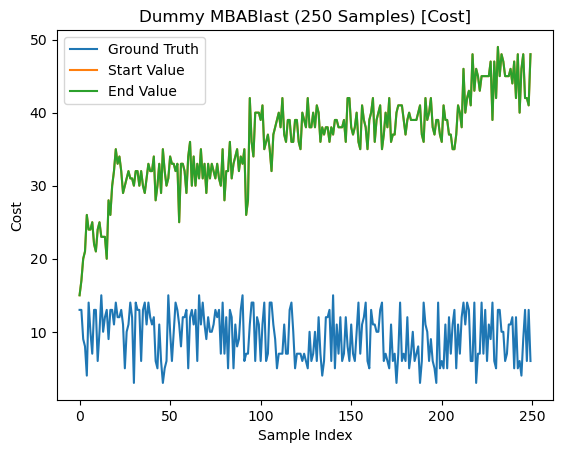

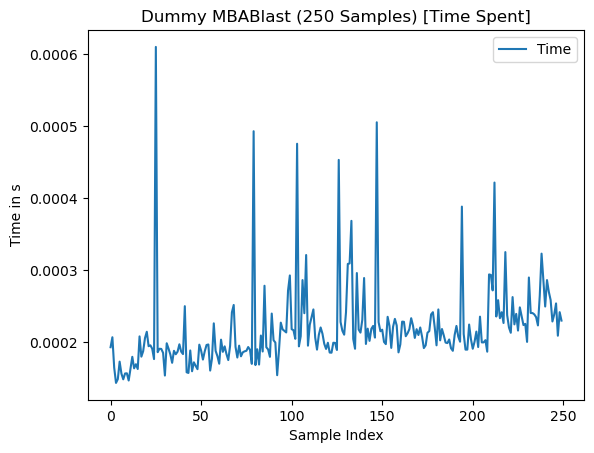

Results for Dummy MBABlast (250 Samples)
Average Ground Cost 9.448
Average Before Cost 36.184
Average After  Cost 36.184
Average Time 0.00021818828582763672
A/B (%) 100.0 %


In [15]:
eval_samples(f"Dummy {DATASET_NAME} ({SAMPLE_AMOUNT} Samples)", samples, [], dummy_strategy)

In [16]:
llp = ferret.LLVMLiteEqualityProvider()
mbabp = ferret.MBABlastEqualityProvider()
qsynth = ferret.QSynthEqualityProvider()
simbaref = ferret.SiMBAEqualityProviderReference()

providers = [llp, mbabp, qsynth, simbaref]
eqprovSet = list(itertools.chain.from_iterable(itertools.combinations(providers, r) for r in range(len(providers)+1)))

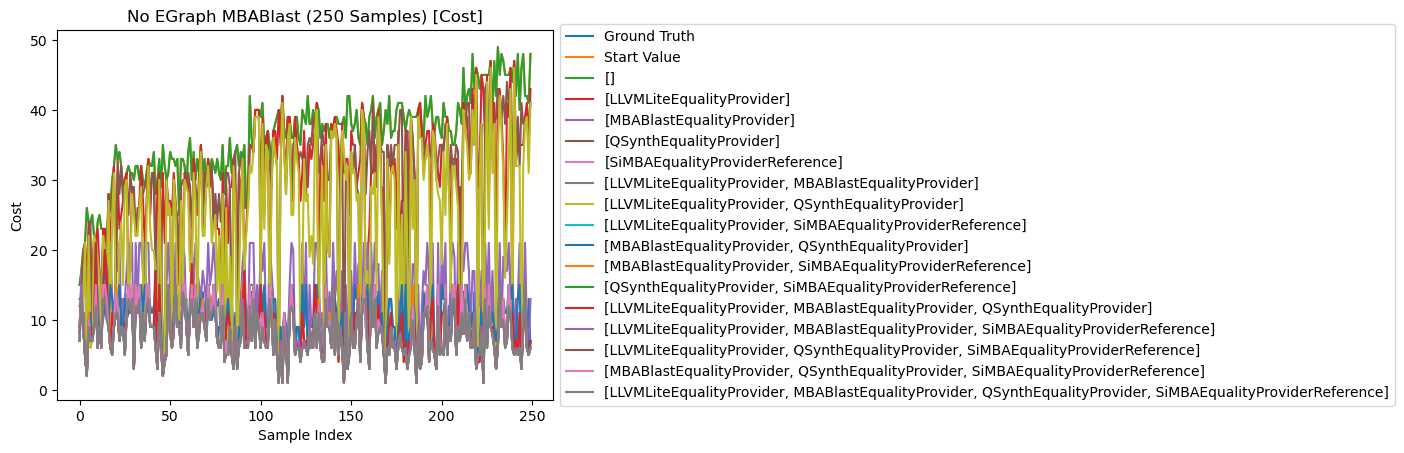

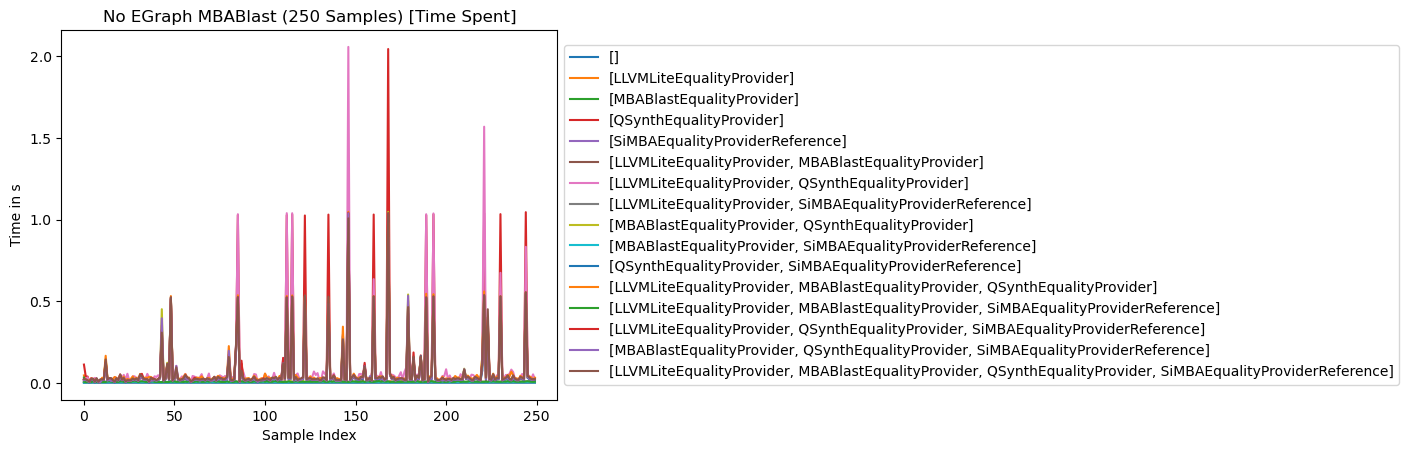

Average Ground Cost 9.448
Average Before Cost 36.184
Results for []
Average After Cost 36.184
Average Time 0.00022698497772216796
A/B (%) 100.0 %
Results for [LLVMLiteEqualityProvider]
Average After Cost 29.84
Average Time 0.004720480918884278
A/B (%) 82.61995641323425 %
Results for [MBABlastEqualityProvider]
Average After Cost 13.768
Average Time 0.002258779525756836
A/B (%) 39.56798944490365 %
Results for [QSynthEqualityProvider]
Average After Cost 29.808
Average Time 0.08621871471405029
A/B (%) 82.41573967826845 %
Results for [SiMBAEqualityProviderReference]
Average After Cost 8.588
Average Time 0.0012584009170532227
A/B (%) 24.976968271449955 %
Results for [LLVMLiteEqualityProvider, MBABlastEqualityProvider]
Average After Cost 9.244
Average Time 0.008243700981140138
A/B (%) 26.890528419923037 %
Results for [LLVMLiteEqualityProvider, QSynthEqualityProvider]
Average After Cost 24.552
Average Time 0.09520438861846924
A/B (%) 67.85357037149981 %
Results for [LLVMLiteEqualityProvider, S

In [17]:
results_nograph = eval_samples_combinations(f"No EGraph {DATASET_NAME} ({SAMPLE_AMOUNT} Samples)", lambda: samples, eqprovSet, no_egraph_strategy)

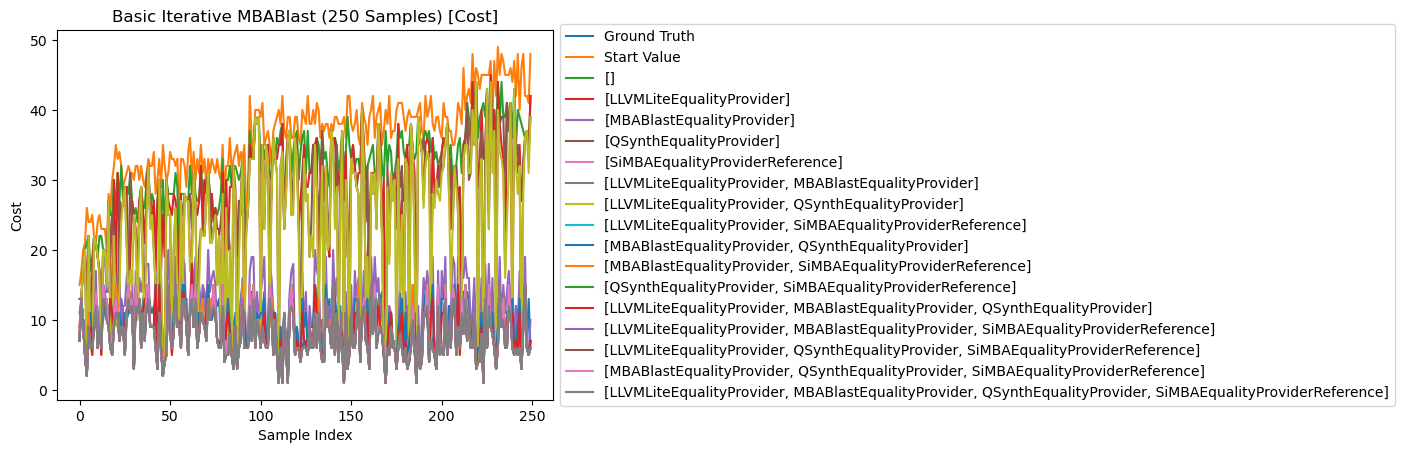

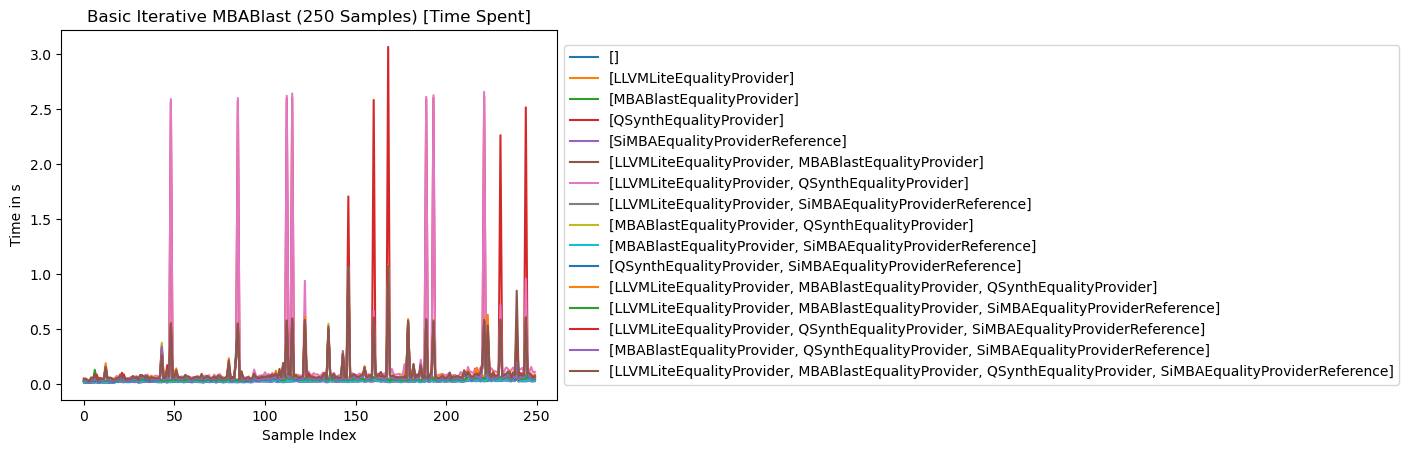

Average Ground Cost 9.448
Average Before Cost 36.184
Results for []
Average After Cost 31.976
Average Time 0.02697614288330078
A/B (%) 88.36758598952026 %
Results for [LLVMLiteEqualityProvider]
Average After Cost 28.084
Average Time 0.050200592041015624
A/B (%) 77.65270663255922 %
Results for [MBABlastEqualityProvider]
Average After Cost 11.948
Average Time 0.026621197700500487
A/B (%) 34.3462079475798 %
Results for [QSynthEqualityProvider]
Average After Cost 25.54
Average Time 0.18744374465942382
A/B (%) 70.61898525429383 %
Results for [SiMBAEqualityProviderReference]
Average After Cost 8.328
Average Time 0.021235456466674806
A/B (%) 24.196445166034568 %
Results for [LLVMLiteEqualityProvider, MBABlastEqualityProvider]
Average After Cost 8.916
Average Time 0.042317686080932615
A/B (%) 25.76767545943352 %
Results for [LLVMLiteEqualityProvider, QSynthEqualityProvider]
Average After Cost 23.364
Average Time 0.18348216819763183
A/B (%) 64.58617395570207 %
Results for [LLVMLiteEqualityProvi

In [18]:
results_basiciter = eval_samples_combinations(f"Basic Iterative {DATASET_NAME} ({SAMPLE_AMOUNT} Samples)", lambda: samples, eqprovSet, basic_iterative_strategy)

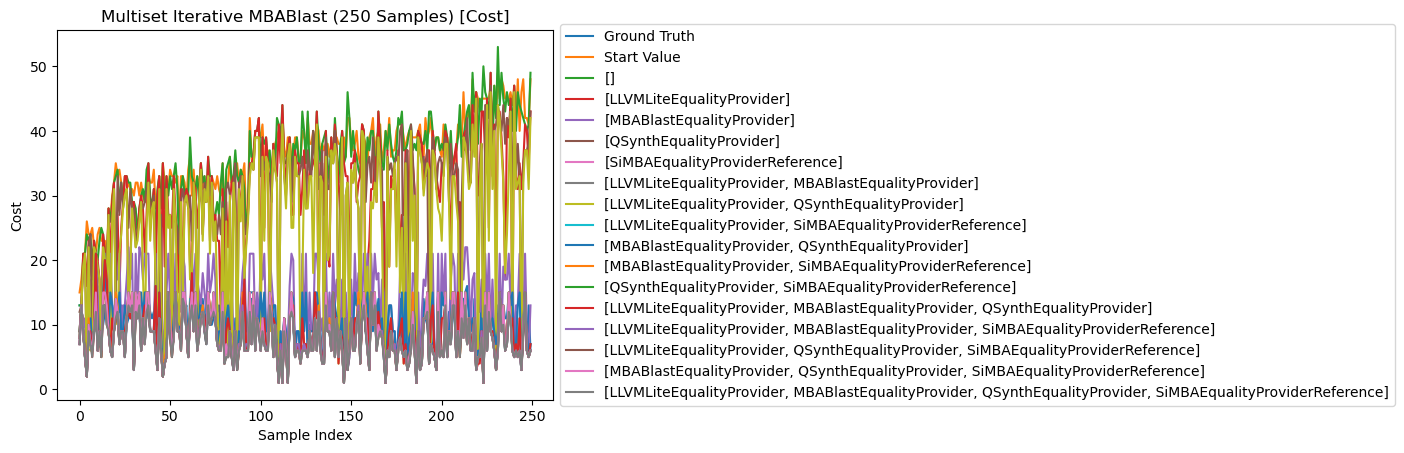

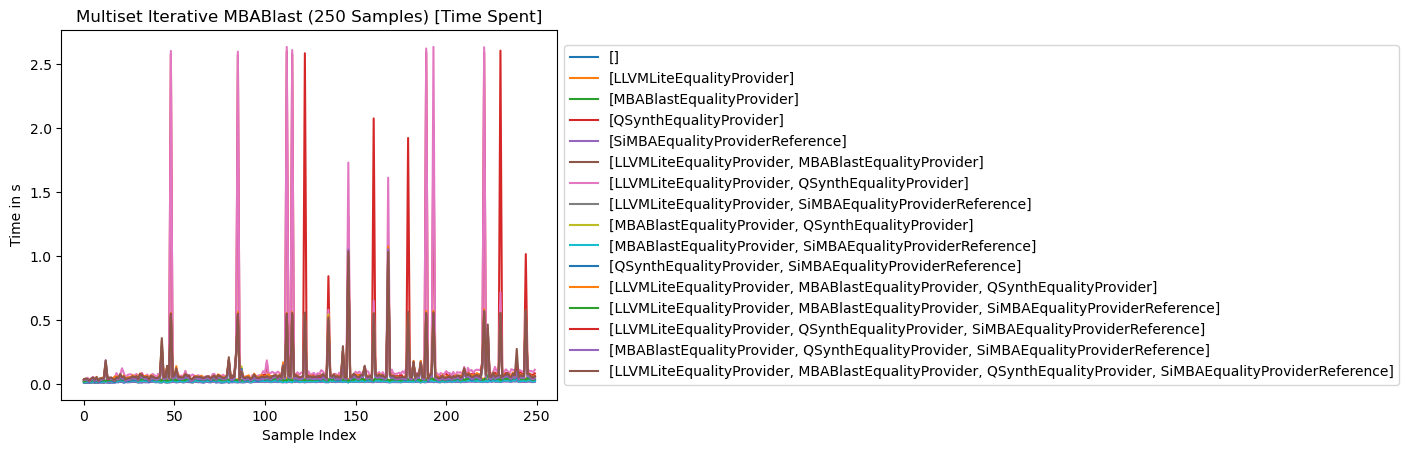

Average Ground Cost 9.448
Average Before Cost 36.184
Results for []
Average After Cost 35.604
Average Time 0.02071197700500488
A/B (%) 98.23997964730893 %
Results for [LLVMLiteEqualityProvider]
Average After Cost 29.94
Average Time 0.03942182731628418
A/B (%) 82.92561312162115 %
Results for [MBABlastEqualityProvider]
Average After Cost 13.824
Average Time 0.021548922538757325
A/B (%) 39.68222678575658 %
Results for [QSynthEqualityProvider]
Average After Cost 29.412
Average Time 0.1840212516784668
A/B (%) 81.4087519420285 %
Results for [SiMBAEqualityProviderReference]
Average After Cost 8.58
Average Time 0.017900707244873047
A/B (%) 24.92990944792054 %
Results for [LLVMLiteEqualityProvider, MBABlastEqualityProvider]
Average After Cost 9.188
Average Time 0.03487000560760498
A/B (%) 26.750012873198298 %
Results for [LLVMLiteEqualityProvider, QSynthEqualityProvider]
Average After Cost 25.252
Average Time 0.1820579710006714
A/B (%) 69.84471800738554 %
Results for [LLVMLiteEqualityProvider, 

In [19]:
results_multisetiter = eval_samples_combinations(f"Multiset Iterative {DATASET_NAME} ({SAMPLE_AMOUNT} Samples)", lambda: samples, eqprovSet, multiset_iterative_strategy)

In [20]:
compare_results(results_nograph, results_basiciter, "No Graph", "Basic Iterative")

Delta Difference Basic Iterative - No Graph
Delta Cost -4.21 |  Delta Time 0.02675s |  []
Delta Cost -1.76 |  Delta Time 0.04548s |  [LLVMLiteEqualityProvider]
Delta Cost -1.82 |  Delta Time 0.02436s |  [MBABlastEqualityProvider]
Delta Cost -4.27 |  Delta Time 0.10123s |  [QSynthEqualityProvider]
Delta Cost -0.26 |  Delta Time 0.01998s |  [SiMBAEqualityProviderReference]
Delta Cost -0.33 |  Delta Time 0.03407s |  [LLVMLiteEqualityProvider, MBABlastEqualityProvider]
Delta Cost -1.19 |  Delta Time 0.08828s |  [LLVMLiteEqualityProvider, QSynthEqualityProvider]
Delta Cost -0.18 |  Delta Time 0.03314s |  [LLVMLiteEqualityProvider, SiMBAEqualityProviderReference]
Delta Cost -0.94 |  Delta Time 0.02921s |  [MBABlastEqualityProvider, QSynthEqualityProvider]
Delta Cost -0.27 |  Delta Time 0.02505s |  [MBABlastEqualityProvider, SiMBAEqualityProviderReference]
Delta Cost -0.24 |  Delta Time 0.02444s |  [QSynthEqualityProvider, SiMBAEqualityProviderReference]
Delta Cost -0.21 |  Delta Time 0.03795

In [21]:
compare_results(results_nograph, results_multisetiter, "No Graph", "Multiset Iterative")

Delta Difference Multiset Iterative - No Graph
Delta Cost -0.58 |  Delta Time 0.02048s |  []
Delta Cost 0.10 |  Delta Time 0.03470s |  [LLVMLiteEqualityProvider]
Delta Cost 0.06 |  Delta Time 0.01929s |  [MBABlastEqualityProvider]
Delta Cost -0.40 |  Delta Time 0.09780s |  [QSynthEqualityProvider]
Delta Cost -0.01 |  Delta Time 0.01664s |  [SiMBAEqualityProviderReference]
Delta Cost -0.06 |  Delta Time 0.02663s |  [LLVMLiteEqualityProvider, MBABlastEqualityProvider]
Delta Cost 0.70 |  Delta Time 0.08685s |  [LLVMLiteEqualityProvider, QSynthEqualityProvider]
Delta Cost -0.02 |  Delta Time 0.02611s |  [LLVMLiteEqualityProvider, SiMBAEqualityProviderReference]
Delta Cost 0.01 |  Delta Time 0.02257s |  [MBABlastEqualityProvider, QSynthEqualityProvider]
Delta Cost -0.01 |  Delta Time 0.02105s |  [MBABlastEqualityProvider, SiMBAEqualityProviderReference]
Delta Cost 0.00 |  Delta Time 0.01931s |  [QSynthEqualityProvider, SiMBAEqualityProviderReference]
Delta Cost -0.06 |  Delta Time 0.02963s 

In [22]:
compare_results(results_basiciter, results_multisetiter, "Basic Iterative", "Multiset Iterative")

Delta Difference Multiset Iterative - Basic Iterative
Delta Cost 3.63 |  Delta Time -0.00626s |  []
Delta Cost 1.86 |  Delta Time -0.01078s |  [LLVMLiteEqualityProvider]
Delta Cost 1.88 |  Delta Time -0.00507s |  [MBABlastEqualityProvider]
Delta Cost 3.87 |  Delta Time -0.00342s |  [QSynthEqualityProvider]
Delta Cost 0.25 |  Delta Time -0.00333s |  [SiMBAEqualityProviderReference]
Delta Cost 0.27 |  Delta Time -0.00745s |  [LLVMLiteEqualityProvider, MBABlastEqualityProvider]
Delta Cost 1.89 |  Delta Time -0.00142s |  [LLVMLiteEqualityProvider, QSynthEqualityProvider]
Delta Cost 0.16 |  Delta Time -0.00703s |  [LLVMLiteEqualityProvider, SiMBAEqualityProviderReference]
Delta Cost 0.95 |  Delta Time -0.00664s |  [MBABlastEqualityProvider, QSynthEqualityProvider]
Delta Cost 0.26 |  Delta Time -0.00400s |  [MBABlastEqualityProvider, SiMBAEqualityProviderReference]
Delta Cost 0.24 |  Delta Time -0.00513s |  [QSynthEqualityProvider, SiMBAEqualityProviderReference]
Delta Cost 0.16 |  Delta Tim

In [23]:
ev_base, time_base, name_base, samples_base = results_multisetiter

print("Listing (time-based) outliers for multiset evaluation")

for j in range(len(ev_base)):
    time_avrg = sum(time_base[j])/samples_base
    print(f"\t{name_base[j]} @ Average {time_avrg}s")
    for i in range(samples_base):
        if time_base[j][i] < time_avrg*4: continue
        print(f"\tIndex {i}: {samples[i]} @ {time_base[j][i]}s")

Listing (time-based) outliers for multiset evaluation
	[] @ Average 0.02071197700500488s
	[LLVMLiteEqualityProvider] @ Average 0.03942182731628418s
	[MBABlastEqualityProvider] @ Average 0.021548922538757325s
	[QSynthEqualityProvider] @ Average 0.1840212516784668s
	Index 48: ('dataset2_64bit', 11 * (x | ~y) + 2 * x - 12 * ~(x | y) - 13 * (x & ~y) - 14 * (x & y), -1 * ~(x ^ y)) @ 2.580501079559326s
	Index 85: ('dataset2_64bit', -2 * ~(x & y) - 11 * ~y + 13 * ~(x | y) + 3 * ~(x | ~y) + 14 * (x & ~y), 1 * (x ^ y)) @ 2.573206663131714s
	Index 112: ('dataset2_64bit', -5 * ~(x ^ y) - 11 * ~(x & ~y) + 14 * ~(x | y) + 9 * ~(x | ~y) - 2 * (x & ~y) + 14 * (x & y), -2 * ~(x & ~x)) @ 2.604416847229004s
	Index 115: ('dataset2_64bit', 7 * ~x - 1 * ~(x ^ y) - 11 * ~(x | y) - 12 * ~(x | ~y) - 5 * (x & ~y) - 4 * (x & y), -5 * ~(x & ~x)) @ 2.5818023681640625s
	Index 122: ('dataset2_64bit', -1 * ~x - 7 * (x | ~y) + 2 * y + 8 * ~(x | y) + 7 * (x & ~y) + 5 * (x & y), 1 * ~(x | ~y)) @ 2.5868940353393555s
	In

In [24]:
sampleSet = samples + []
#random.shuffle(sampleSet)
#sampleSet = sampleSet[:1]

sampleSet = [sampleSet[48]]

for eqprovs in [[], [llp], [mbabp], [qsynth], [simbaref]]:
    print(str([eqprov.name() for eqprov in eqprovs]).replace("'", "").replace('"', ""))
    for expr in sampleSet:
        #eval_eqprovs(expr, eqprovs, basic_iterative_strategy, True)
        eval_eqprovs(expr, eqprovs, multiset_iterative_strategy, True)

NameError: name 'allSet' is not defined

In [ ]:
#allSet = [[], [mbabp], [qsynth], [simbaref]] #  [llp]
#results_basicall_norun = eval_samples_combinations(f"Basic All No Run {DATASET_NAME} ({SAMPLE_AMOUNT} Samples)", lambda: samples,  allSet, basic_all_strategy_norun)

In [ ]:
#compare_results(results_nograph, results_basicall_norun, "No Graph", " Basic All No Run")